<a href="https://colab.research.google.com/github/LuisRoblero01/Redes-Neuronales-Recurrentes-RNN-/blob/main/Proyecto_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **PROYECTO 2: Detección de cancer de piel**

Se usa una base de datos de imágenes para entrenar una Red Neuronal Convolucional (CNN) para la clasificación de 9 clases distintas de lesiones cutáneas.

El dataset se divide en imágenes de entrenamiento y prueba, las cuales se clasifican en:

* **Queratosis benigna pigmentada**
* **Melanoma**
* **Lesión vascular**
* **Queratosis actínica**
* **Carcinoma de células escamosas**
* **Carcinoma basocelular**
* **Queratosis seborréica**
* **Dermatofibroma**
* **Nevo (o lunar)**


In [1]:
import kagglehub
import os
import pandas as pd

# Download latest version
path = kagglehub.dataset_download("jaiahuja/skin-cancer-detection")

# Datos
files = os.listdir(path)
print(files)

SkinCancer = os.listdir(os.path.join(path, 'Skin cancer ISIC The International Skin Imaging Collaboration'))
print(SkinCancer)

TrainData = os.path.join(path, 'Skin cancer ISIC The International Skin Imaging Collaboration', 'Train')
print(TrainData)

100%|██████████| 786M/786M [00:36<00:00, 22.8MB/s]

Extracting files...


['Skin cancer ISIC The International Skin Imaging Collaboration']
['Train', 'Test']
/root/.cache/kagglehub/datasets/jaiahuja/skin-cancer-detection/versions/1/Skin cancer ISIC The International Skin Imaging Collaboration/Train


Se importan las imagenes de entrenamiento

In [2]:
import os
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# Tamaño deseado de las imágenes
img_size = (128, 128)

# Filtro
filtro = 'canny'

# Recorrer todas las carpetas
imagenes = []
etiquetas = []
for clase in os.listdir(TrainData):
    clase_path = os.path.join(TrainData, clase)

    if not os.path.isdir(clase_path):
        continue

    for archivo in tqdm(os.listdir(clase_path), desc=f'Cargando {clase}'):

        img_path = os.path.join(clase_path, archivo)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        img = cv2.resize(img, img_size)

        if filtro == 'canny':
            img = cv2.Canny(img, 100, 200)
        elif filtro == 'sobel':
            sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
            sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
            img = cv2.magnitude(sobelx, sobely)
        elif filtro == 'laplacian':
            img = cv2.Laplacian(img, cv2.CV_64F)

        img = img / 255.0

        imagenes.append(img)
        etiquetas.append(clase)

Cargando melanoma: 100%|██████████| 438/438 [00:03<00:00, 142.72it/s]


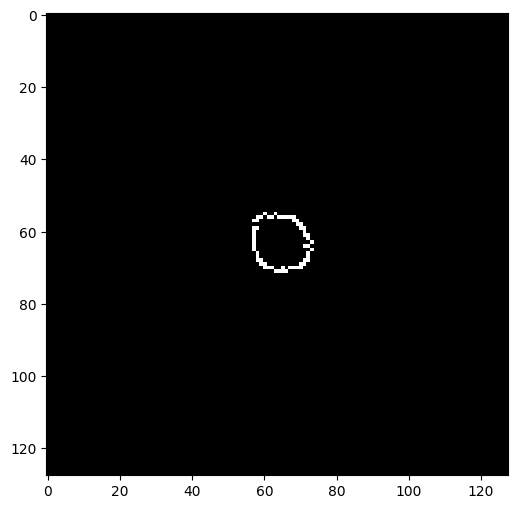

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12,6))
plt.imshow(imagenes[300], cmap='gray')
plt.show()

In [4]:
# Convertir a arreglos NumPy
X = np.array(imagenes)
y = np.array(etiquetas)

X = X.reshape(-1, X.shape[1], X.shape[2], 1)

print("Forma de X:", X.shape)
print("Cantidad de etiquetas:", y.shape)

Forma de X: (2239, 128, 128, 1)
Cantidad de etiquetas: (2239,)


In [5]:
from sklearn.preprocessing import LabelEncoder

# Codificar las clases
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print("Clases codificadas:", np.unique(y_encoded))

Clases codificadas: [0 1 2 3 4 5 6 7 8]


Se importan las imagenes de prueba

In [6]:
test_path = os.path.join(path, 'Skin cancer ISIC The International Skin Imaging Collaboration', 'Test')

imagenes_test = []
etiquetas_test = []

for clase in os.listdir(test_path):
    clase_path = os.path.join(test_path, clase)

    if not os.path.isdir(clase_path):
        continue

    for archivo in tqdm(os.listdir(clase_path), desc=f'Cargando Test {clase}'):
        img_path = os.path.join(clase_path, archivo)

        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        img = cv2.resize(img, img_size)

        if filtro == 'canny':
            img = cv2.Canny(img, 100, 200)
        elif filtro == 'sobel':
            sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)
            sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)
            img = cv2.magnitude(sobelx, sobely)
        elif filtro == 'laplacian':
            img = cv2.Laplacian(img, cv2.CV_64F)

        img = img / 255.0

        imagenes_test.append(img)
        etiquetas_test.append(clase)

# Convertir a NumPy
X_test = np.array(imagenes_test)
y_test = np.array(etiquetas_test)

# Dar forma
X_test = X_test.reshape(-1, img_size[0], img_size[1], 1)

Cargando Test melanoma: 100%|██████████| 16/16 [00:00<00:00, 289.17it/s]


In [7]:
y_test_encoded = le.transform(y_test)

## **Entrenamiento con filtro**

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization

model = Sequential()
model.add(Conv2D(32, (3,3), activation='relu', input_shape=(128,128,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(9, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 57600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │       3,686,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 9)                   │             585 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,705,865 (14.14 MB)

 Trainable params: 3,705,865 (14.14 MB)

 Non-trainable params: 0 (0.00 B)

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.1,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(X)

In [10]:
history = model.fit(datagen.flow(X, y_encoded, batch_size=32), epochs=50, validation_data=(X_test, y_test_encoded))

Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 16s 135ms/step - accuracy: 0.1735 - loss: 2.1174 - val_accuracy: 0.1356 - val_loss: 2.2007
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.1956 - loss: 2.0501 - val_accuracy: 0.1695 - val_loss: 2.2582
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.2030 - loss: 2.0373 - val_accuracy: 0.1356 - val_loss: 2.2856
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - accuracy: 0.2332 - loss: 2.0091 - val_accuracy: 0.1864 - val_loss: 2.2100
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.2243 - loss: 2.0192 - val_accuracy: 0.1780 - val_loss: 2.2540
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 5s 47ms/step - accuracy: 0.2406 - loss: 1.9946 - val_accuracy: 0.1864 - val_loss: 2.2580
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2513 - loss: 1.9793 - val_accuracy: 0.1610 - val_loss: 2.2426
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - accuracy: 0.2417 - loss: 1.9720 - val_accuracy: 0.1525 - val_loss: 

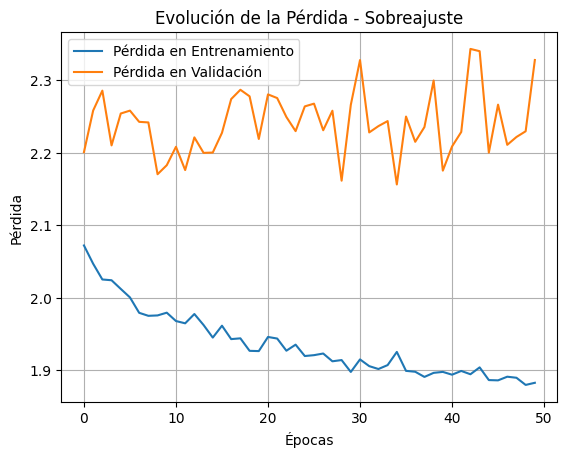

In [11]:
plt.plot(history.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history.history['val_loss'], label='Pérdida en Validación')
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Evolución de la Pérdida - Sobreajuste")
plt.legend()
plt.grid()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 164ms/step


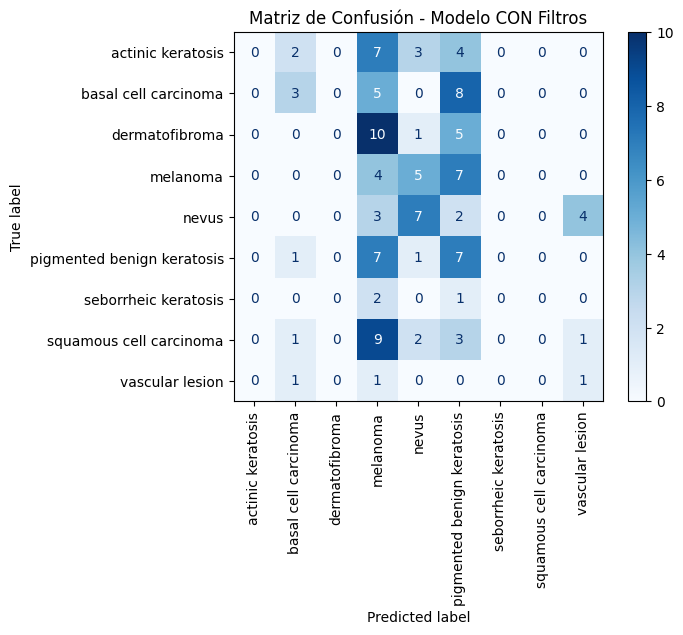

In [12]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

cm = confusion_matrix(y_test_encoded, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
disp.plot(cmap='Blues', xticks_rotation=90)
plt.title('Matriz de Confusión - Modelo CON Filtros')
plt.show()

## **Entrenamiento sin filtro**

In [13]:
imagenes_sin_filtro = []
etiquetas_sin_filtro = []

for clase in os.listdir(TrainData):
    clase_path = os.path.join(TrainData, clase)

    if not os.path.isdir(clase_path):
        continue

    for archivo in tqdm(os.listdir(clase_path), desc=f'Cargando sin filtro {clase}'):
        img_path = os.path.join(clase_path, archivo)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            continue

        img = cv2.resize(img, img_size)

        img = img / 255.0

        imagenes_sin_filtro.append(img)
        etiquetas_sin_filtro.append(clase)

# Convertir a NumPy
X_sin_filtro = np.array(imagenes_sin_filtro)
y_sin_filtro = np.array(etiquetas_sin_filtro)

X_sin_filtro = X_sin_filtro.reshape(-1, img_size[0], img_size[1], 1)

y_sin_filtro_encoded = le.transform(y_sin_filtro)

Cargando sin filtro melanoma: 100%|██████████| 438/438 [00:02<00:00, 149.64it/s]


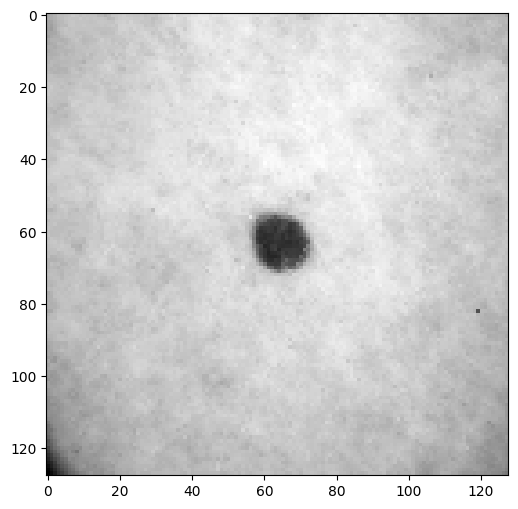

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12,6))
plt.imshow(imagenes_sin_filtro[300], cmap='gray')
plt.show()

In [15]:
history_sin_filtro = model.fit(datagen.flow(X_sin_filtro, y_sin_filtro_encoded, batch_size=32), epochs=50, validation_data=(X_test, y_test_encoded))

Epoch 1/50
 1/70 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.1875 - loss: 2.1134

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2004 - loss: 2.0461 - val_accuracy: 0.1525 - val_loss: 2.3306
Epoch 2/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - accuracy: 0.2212 - loss: 2.0359 - val_accuracy: 0.1525 - val_loss: 2.3270
Epoch 3/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 46ms/step - accuracy: 0.2084 - loss: 2.0247 - val_accuracy: 0.1610 - val_loss: 2.3513
Epoch 4/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.2223 - loss: 2.0080 - val_accuracy: 0.1610 - val_loss: 2.3429
Epoch 5/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - accuracy: 0.2349 - loss: 2.0203 - val_accuracy: 0.1610 - val_loss: 2.3480
Epoch 6/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - accuracy: 0.2497 - loss: 1.9817 - val_accuracy: 0.1610 - val_loss: 2.3563
Epoch 7/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - accuracy: 0.2244 - loss: 1.9882 - val_accuracy: 0.1610 - val_loss: 2.3703
Epoch 8/50
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 47ms/step - accuracy: 0.2181 - loss: 1.9941 - val_accuracy: 0.1695 - val_loss: 2.

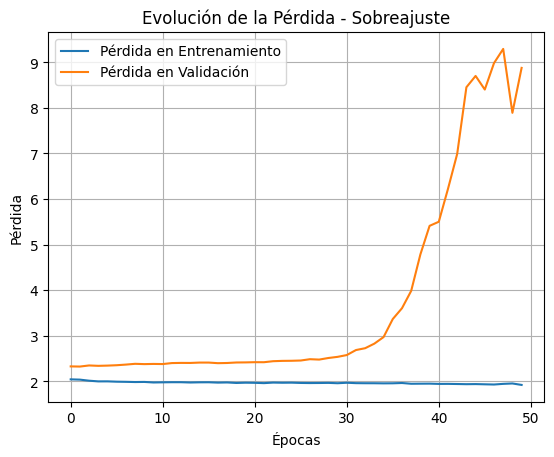

In [16]:
plt.plot(history_sin_filtro.history['loss'], label='Pérdida en Entrenamiento')
plt.plot(history_sin_filtro.history['val_loss'], label='Pérdida en Validación')
plt.xlabel("Épocas")
plt.ylabel("Pérdida")
plt.title("Evolución de la Pérdida - Sobreajuste")
plt.legend()
plt.grid()
plt.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


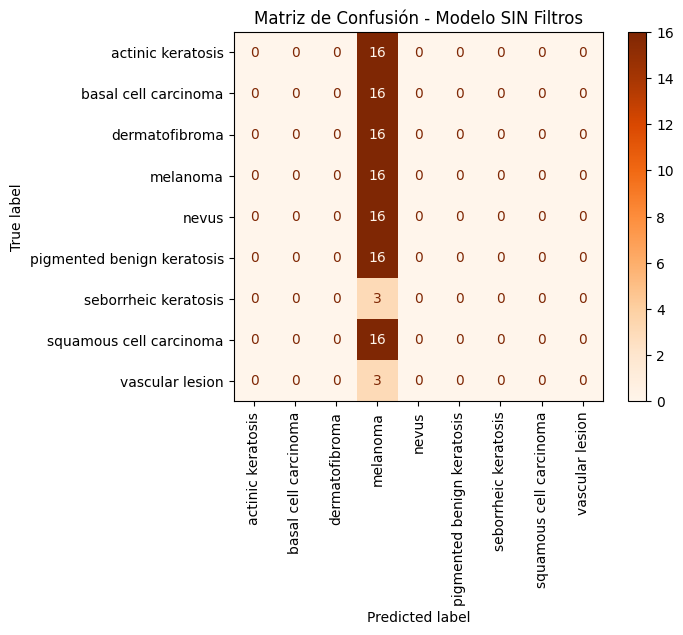

In [17]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predecir en el conjunto de prueba usando el modelo entrenado sin filtros
y_pred_probs_sin_filtro = model.predict(X_test)
y_pred_sin_filtro = np.argmax(y_pred_probs_sin_filtro, axis=1)

# Crear matriz de confusión
cm_sin_filtro = confusion_matrix(y_test_encoded, y_pred_sin_filtro)

# Mostrar
disp_sin_filtro = ConfusionMatrixDisplay(confusion_matrix=cm_sin_filtro, display_labels=le.classes_)
disp_sin_filtro.plot(cmap='Oranges', xticks_rotation=90)
plt.title('Matriz de Confusión - Modelo SIN Filtros')
plt.show()

## **RESULTADOS CON Y SIN FILTRO**

Se puede observar como el aplicar un filtro a las imagenes antes de entrenar a la red neuronal es de ayuda y máximiza la precisión de predicción.

Sin embargo, debido a la naturaleza de las imagenes, es dificil obtener una precision alta, esto porque el filtro no reconoce al 100% la forma de las diferentes lesiones cutaneas, lo que provoca que muchas imagenes se vean completamente negras y se pierde información valiosa.